# Random Forest


In [1]:
from qiime2 import Visualization
from qiime2 import Artifact
import pandas as pd
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.preprocessing import label_binarize
import matplotlib.cm as cm
import numpy as np
import matplotlib.colors as mcolors

%matplotlib inline

In [2]:
workdir = '/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/berries'
%cd $workdir

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/berries


## Load data

In [ ]:
%%bash 

# subset to only harvest samples before fitting 
qiime feature-table filter-samples \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --p-where "[Time_point]='Harvest'" \
  --o-filtered-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza

In [ ]:
!qiime feature-table summarize --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza --o-visualization /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qzv

## Harvest: Random Forest - Nested Cross Validation


In [ ]:
%%bash 

rm -r must-harvestclassify-NCV-plot

qiime sample-classifier classify-samples-ncv \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-metadata-column Plot_ID \
  --p-random-state 666 \
  --p-n-jobs 10 \
  --p-n-estimators 10000 \
  --p-estimator 'RandomForestClassifier' \
  --output-dir ./must-harvestclassify-NCV-plot/
  

qiime sample-classifier confusion-matrix \
  --i-predictions must-harvestclassify-NCV-plot/predictions.qza \
  --i-probabilities must-harvestclassify-NCV-plot/probabilities.qza \
  --m-truth-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-truth-column Plot_ID \
  --o-visualization must-harvestclassify-NCV-plot/ncv_confusion_matrix.qzv

In [ ]:
Visualization.load('must-harvestclassify-NCV-plot/ncv_confusion_matrix.qzv')

## Harvest dense sampling 2021: Random Forest - Nested Cross Validation

> also tried 'KNeighborsClassifier' but that had bad performance

* note. decreasing the estimator to 1000 decreased the AUC to 0.83 - keep high! 

In [ ]:
%%bash 

rm -r must-harvest21classify-NCV-plot

qiime sample-classifier classify-samples-ncv \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest21_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-metadata-column Plot_ID \
  --p-random-state 666 \
  --p-n-jobs 10 \
  --p-n-estimators 20000 \
  --p-estimator 'RandomForestClassifier' \
  --output-dir ./must-harvest21classify-NCV-plot/
  

qiime sample-classifier confusion-matrix \
  --i-predictions must-harvest21classify-NCV-plot/predictions.qza \
  --i-probabilities must-harvest21classify-NCV-plot/probabilities.qza \
  --m-truth-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-truth-column Plot_ID \
  --o-visualization must-harvest21classify-NCV-plot/ncv_confusion_matrix.qzv

In [ ]:
Visualization.load('must-harvest21classify-NCV-plot/ncv_confusion_matrix.qzv')

### Nicer visualizations!

In [3]:
# Load predictions and probabilities from QIIME2 artifacts
predictions = Artifact.load("must-harvest21classify-NCV-plot/predictions.qza").view(pd.Series)
probabilities = Artifact.load("must-harvest21classify-NCV-plot/probabilities.qza").view(pd.DataFrame)

# Load the ground truth labels from metadata
metadata = pd.read_csv("/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv", sep="\t", index_col=0)
y_true = metadata.loc[predictions.index, "Plot_ID"]  # Align indices

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/q2_sample_classifier/_transformer.py:69: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return pd.to_numeric(df.iloc[:, 0], errors='ignore')


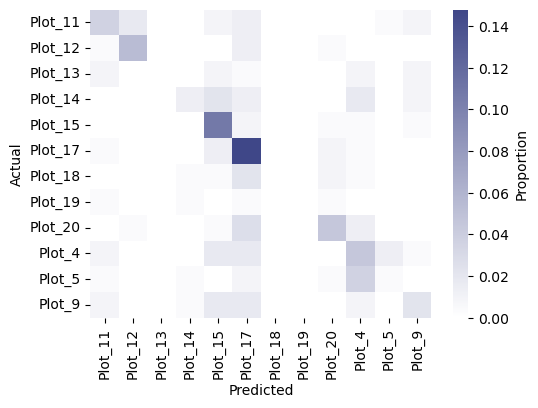

In [6]:
# Assuming y_true and predictions are already defined
cm = confusion_matrix(y_true, predictions)
labels = sorted(y_true.unique())  # Ensure correct label ordering

# Normalize the confusion matrix by the total sum to get proportions
cm_normalized = cm.astype('float') / cm.sum()

# Strip 'Lavaux_' from all labels
clean_labels = [label.replace("Lavaux_", "") for label in labels]

# Define custom colormap from light blue (not white) to deep blue
colors = ["#FFFFFF", "#3F4788FF"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=256)

# Create the heatmap with normalized confusion matrix
plt.figure(figsize=(5.5, 4))
sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap=custom_cmap, 
            cbar_kws={'label': 'Proportion'},  # Add colorbar label
            xticklabels=clean_labels, yticklabels=clean_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

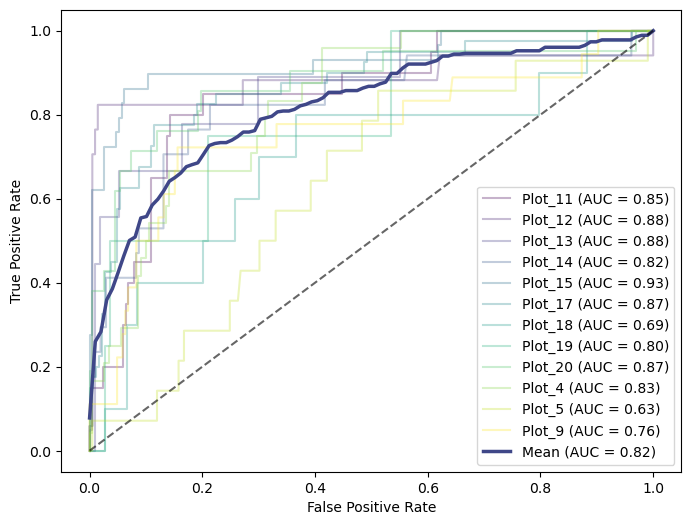

In [7]:
# Convert categorical labels to one-hot encoding
y_true_bin = label_binarize(y_true, classes=labels)

# Get Viridis colors for each class
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))  # Use plt.cm.viridis

# Compute ROC curve and AUC for each class
plt.figure(figsize=(8, 6))
all_fpr = np.linspace(0, 1, 100)  # Common FPR points for interpolation
mean_tpr = np.zeros_like(all_fpr)  # To store mean TPR

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probabilities[label])
    roc_auc = auc(fpr, tpr)
    
    # Remove "Lavaux_" from the label in the legend
    clean_label = label.replace("Lavaux_", "")

    # Plot individual class ROC curve with Viridis color
    plt.plot(fpr, tpr, label=f"{clean_label} (AUC = {roc_auc:.2f})", 
             color=viridis_colors[i], alpha=0.3, linewidth=1.5)

    # Interpolate TPR for averaging
    mean_tpr += np.interp(all_fpr, fpr, tpr)  

# Compute mean ROC curve
mean_tpr /= len(labels)
mean_auc = auc(all_fpr, mean_tpr)

# Plot the **average ROC curve** (bold, different color)
plt.plot(all_fpr, mean_tpr, color="#3F4788FF", linewidth=2.5, label=f"Mean (AUC = {mean_auc:.2f})")

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.show()


## Harvest dense sampling 2021 only large sample numbers : Random Forest - Nested Cross Validation

> also tried 'KNeighborsClassifier' but that had bad performance

* note. decreasing the estimator to 1000 decreased the AUC to 0.83 - keep high! 

In [ ]:
md = pd.read_csv('/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv', sep='\t')
md

In [ ]:
%%bash 

# subset to only samples with > 10 
qiime feature-table filter-samples \
  --i-table /home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/must_harvest_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --p-where "Plot_ID NOT IN ('Lavaux_Plot_13', 'Lavaux_Plot_18', 'Lavaux_Plot_19')" \
  --o-filtered-table must_harvest21_NVCsubset_filtered_table.qza

In [ ]:
%%bash 

rm -r must-harvest21-subset-classify-NCV-plot

qiime sample-classifier classify-samples-ncv \
  --i-table must_harvest21_NVCsubset_filtered_table.qza \
  --m-metadata-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-metadata-column Plot_ID \
  --p-random-state 666 \
  --p-n-jobs 10 \
  --p-n-estimators 20000 \
  --p-estimator 'RandomForestClassifier' \
  --output-dir ./must-harvest21-subset-classify-NCV-plot/
  

qiime sample-classifier confusion-matrix \
  --i-predictions must-harvest21-subset-classify-NCV-plot/predictions.qza \
  --i-probabilities must-harvest21-subset-classify-NCV-plot/probabilities.qza \
  --m-truth-file /home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv \
  --m-truth-column Plot_ID \
  --o-visualization must-harvest21-subset-classify-NCV-plot/ncv_confusion_matrix.qzv

In [ ]:
Visualization.load('must-harvest21-subset-classify-NCV-plot/ncv_confusion_matrix.qzv')

### Nicer visualizations

In [8]:
# Load predictions and probabilities from QIIME2 artifacts
predictions = Artifact.load("must-harvest21-subset-classify-NCV-plot/predictions.qza").view(pd.Series)
probabilities = Artifact.load("must-harvest21-subset-classify-NCV-plot/probabilities.qza").view(pd.DataFrame)

# Load the ground truth labels from metadata
metadata = pd.read_csv("/home/lfloerl/microterroir/Microbiome/Metadata/ITS_lavaux.tsv", sep="\t", index_col=0)
y_true = metadata.loc[predictions.index, "Plot_ID"]  # Align indices

/scratch/lfloerl/.condaenvs/qiime2-amplicon-2024.10/lib/python3.10/site-packages/q2_sample_classifier/_transformer.py:69: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  return pd.to_numeric(df.iloc[:, 0], errors='ignore')


In [29]:
!pwd

/home/lfloerl/cloud/lfloerl/Microterroir/artifacts/ITS/lavaux/spatio-temporal/berries


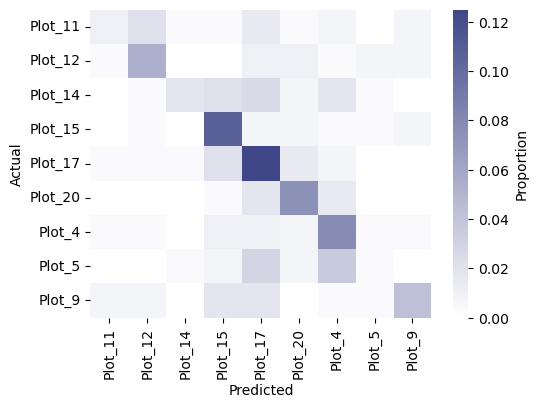

In [12]:
# Assuming y_true and predictions are already defined
cm = confusion_matrix(y_true, predictions)
labels = sorted(y_true.unique())  # Ensure correct label ordering

# Normalize the confusion matrix by the total sum to get proportions
cm_normalized = cm.astype('float') / cm.sum()

# Strip 'Lavaux_' from all labels
clean_labels = [label.replace("Lavaux_", "") for label in labels]

# Define custom colormap from light blue (not white) to deep blue
colors = ["#FFFFFF", "#3F4788FF"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("custom", colors, N=256)

# Create the heatmap with normalized confusion matrix
plt.figure(figsize=(5.5, 4))
sns.heatmap(cm_normalized, annot=False, fmt=".2f", cmap=custom_cmap, 
            cbar_kws={'label': 'Proportion'},  # Add colorbar label
            xticklabels=clean_labels, yticklabels=clean_labels)

plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RF_ConfusionMatrix_must-harvest21-subset-classify-NCV.png', dpi=1000, bbox_inches='tight')  

plt.show()

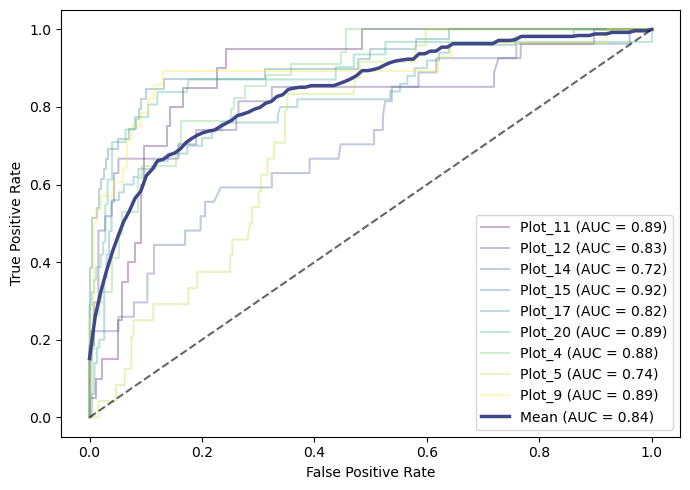

In [13]:
# Convert categorical labels to one-hot encoding
y_true_bin = label_binarize(y_true, classes=labels)

# Get Viridis colors for each class
viridis_colors = plt.cm.viridis(np.linspace(0, 1, len(labels)))  # Use plt.cm.viridis

# Compute ROC curve and AUC for each class
plt.figure(figsize=(7, 5))
all_fpr = np.linspace(0, 1, 100)  # Common FPR points for interpolation
mean_tpr = np.zeros_like(all_fpr)  # To store mean TPR

for i, label in enumerate(labels):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probabilities[label])
    roc_auc = auc(fpr, tpr)
    
    # Remove "Lavaux_" from the label in the legend
    clean_label = label.replace("Lavaux_", "")

    # Plot individual class ROC curve with Viridis color
    plt.plot(fpr, tpr, label=f"{clean_label} (AUC = {roc_auc:.2f})", 
             color=viridis_colors[i], alpha=0.3, linewidth=1.5)

    # Interpolate TPR for averaging
    mean_tpr += np.interp(all_fpr, fpr, tpr)  

# Compute mean ROC curve
mean_tpr /= len(labels)
mean_auc = auc(all_fpr, mean_tpr)

# Plot the **average ROC curve** (bold, different color)
plt.plot(all_fpr, mean_tpr, color="#3F4788FF", linewidth=2.5, label=f"Mean (AUC = {mean_auc:.2f})")

# Diagonal line (random classifier)
plt.plot([0, 1], [0, 1], "k--", alpha=0.6)

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
#plt.title("ROC Curve")
plt.legend(loc="lower right")

plt.savefig('/home/lfloerl/cloud/lfloerl/Microterroir/Figures/RF_AUC_must-harvest21-subset-classify-NCV.png', dpi=1000, bbox_inches='tight')  

plt.tight_layout()
plt.show()